# Variational Autoencoder 

 ![대체 텍스트](https://drive.google.com/uc?id=1TYKx4NcNgeoILad7bdjPb59jwQXxS993)

[출처 : https://www.youtube.com/watch?v=rNh2CrTFpm4]
 

## TensorFlow 및 기타 라이브러리 가져오기

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)


## MNIST 데이터 셋 로드

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)
n_samples = mnist.train.num_examples

W0807 05:48:51.326843 139765526951808 deprecation.py:323] From <ipython-input-2-1c19054655b8>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0807 05:48:51.328531 139765526951808 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0807 05:48:51.329556 139765526951808 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting MNIST_data/train-images-idx3-ubyte.gz


W0807 05:48:51.639190 139765526951808 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0807 05:48:51.642405 139765526951808 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W0807 05:48:51.701383 139765526951808 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be remove

Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## VAE 모델 구축

   
### Keypoint : 손실 함수 정의

#### VAE는 Log Likelihood에 대한 ELBO를 극대화 함으로써 최적화 합니다.

![대체 텍스트](https://drive.google.com/uc?id=1iNNT4PBS3dUeJ4ZYPmqWaU_7-ZUJRYyg)

[출처 :https://www.youtube.com/watch?v=rNh2CrTFpm4]

In [0]:
class VariationalAutoencoder(object):
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
      
      self.network_architecture = network_architecture
      # 파라미터 정의
      self.transfer_fct = transfer_fct 
      self.learning_rate = learning_rate 
      self.batch_size = batch_size

      # Placeholder 정의
      self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])

      # Create autoencoder network
      self._create_network()

      # Define loss function based variational upper-bound and corresponding optimizer
      self._create_loss_optimizer()

      # 텐서 플로우 변수 초기화
      init = tf.global_variables_initializer()

      # 세션 시작
      self.sess = tf.InteractiveSession()
      self.sess.run(init)
             
    #인코더,디코더의 가중치와 바이어스를 초기화 하는 함수
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_gener_1, n_hidden_gener_2, n_input, n_z):
    
        all_weights = dict()
        all_weights['weights_encoder'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        
        all_weights['biases_encoder'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        
        all_weights['weights_decoder'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        
        all_weights['biases_decoder'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        
        return all_weights
   
    def _encoder_network(self, weights, biases):
        # Encoder = Recognition network
        # Q(z|X) -- encoder 
        # 정규분포의 잠재공간에 입력데이터를 매핑하는 확률론적 인코더네트워크 생성 
        
        #2개 fc층을 생성
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) 
        #2번째 층의 출력을 z_mean(평균)와 z_log_sigma(표준편차)에 연결
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),biases['out_mean']) 
        z_log_sigma = tf.add(tf.matmul(layer_2, weights['out_log_sigma']), biases['out_log_sigma'])
        return (z_mean, z_log_sigma)

    def _decoder_network(self, weights, biases):
        # 잠재공간을 Bernouli분포에 매핑하는 확률론적 디코더네트워크 생성
        # Decoder = Generation network
        # 2개 fc층 생성
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']),biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),biases['b2']))
        
        #복원된 데이터 분포의 평균을 (0,1)범위로 출력
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
        return x_reconstr_mean
            
    
    def _create_network(self):
        # 오토인코더의 가중치 및 바이어스 초기화
        network_weights = self._initialize_weights(**self.network_architecture)

        # 인코더 네트워크를 사용하여 잠재 공간에서의 가우스 분포의 평균과 (로그)표준편차를 결정
        self.z_mean, self.z_log_sigma = self._encoder_network(network_weights["weights_encoder"], network_weights["biases_encoder"])

        # 가우시안 분포로 부터 한개의 z를 샘플링
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        
        # 잠재변수 z 선언 (= 𝜇 + 𝜎 * 𝜀)
        self.z = tf.add(self.z_mean,tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma)), eps))

        # 디코더 네트워크를 사용하여 복원된 데이터의 베르누이 분포 평균 결정
        self.x_reconstr_mean = self._decoder_network(network_weights["weights_decoder"],network_weights["biases_decoder"])
        
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1_The reconstruction loss 
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean) + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),1)
        # 2_Latent loss is Kullback Leibler Loss
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma - tf.square(self.z_mean) - tf.exp(self.z_log_sigma), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss) # average over batch
        # Use ADAM optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
            
        
    def fit(self, X):
        #미니배치 모델을 훈련시킴(cost 반환) 
        opt, cost = self.sess.run((self.optimizer, self.cost),feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        # 잠재 공간안으로 데이터를 맵핑하여 변환함.
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        #잠재된 공간으로부터 데이터를 샘플링하여 생성함.
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        # 주어진 데이터를 복원 하기위해 VAE를 사용.
        return self.sess.run(self.x_reconstr_mean,feed_dict={self.x: X})

In [0]:
# Xavier Initialization : Weight 초기화 방법 중 하나로 표준 정규 분포를 입력 개수의 표준 편차로 나눔
def xavier_init(fan_in, fan_out, constant=1): 
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

## Training



### 미니 배치를 사용하여 VAE Train함수 정의

In [0]:
def train(network_architecture, learning_rate=0.001, batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture,learning_rate=learning_rate,batch_size=batch_size)
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Epoch당 로그 표시
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

### Trainning start!

이제 네트워크 토폴로지를 지정하기만 하면 MNIST에서 VAE를 학습할 수 있습니다. 

####2개의 Latent space를 가진 VAE 훈련 (z = 2) 

In [0]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae2d = train(network_architecture, training_epochs=75)

Epoch: 0001 cost= 189.942932240
Epoch: 0006 cost= 153.421998790
Epoch: 0011 cost= 147.835444586
Epoch: 0016 cost= 145.450383883
Epoch: 0021 cost= 143.777885382
Epoch: 0026 cost= 142.796931444
Epoch: 0031 cost= 141.974248740
Epoch: 0036 cost= 141.420707453
Epoch: 0041 cost= 140.794215726
Epoch: 0046 cost= 140.352970886
Epoch: 0051 cost= 139.981556924
Epoch: 0056 cost= 139.609949216
Epoch: 0061 cost= 139.352850800
Epoch: 0066 cost= 139.107881664
Epoch: 0071 cost= 138.828954787


### z = 20

In [0]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space
vae20d = train(network_architecture, training_epochs=75)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 175.385715582
Epoch: 0006 cost= 108.735497520
Epoch: 0011 cost= 103.660544212
Epoch: 0016 cost= 101.065984677
Epoch: 0021 cost= 99.553647711
Epoch: 0026 cost= 98.582706340
Epoch: 0031 cost= 97.840509602
Epoch: 0036 cost= 97.176331967
Epoch: 0041 cost= 96.680742978
Epoch: 0046 cost= 96.224940088
Epoch: 0051 cost= 95.913286993
Epoch: 0056 cost= 95.551155548
Epoch: 0061 cost= 95.246001656
Epoch: 0066 cost= nan
Epoch: 0071 cost= nan


## Reconstruction 결과
VAE가 잠재 변수에서 이미지를 얼마나 잘 복원 할 수 있는지 확인합니다.

### Z = 2

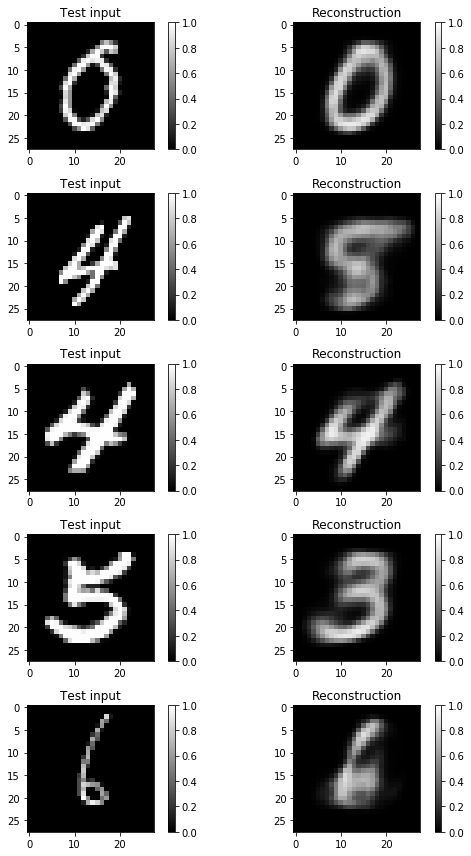

In [0]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae2d.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

### Z = 20

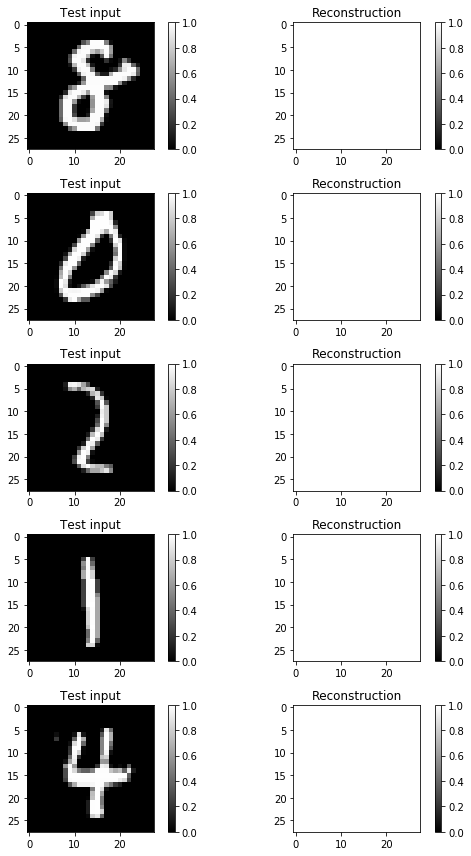

In [0]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae20d.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

In [0]:
print(vae2d.n_layers)
print(vae20d.n_layers)

AttributeError: ignored

## Latent space visualization(1)
2차원과 20차원의 Latent Space를 T-SNE 그래프로 확인합니다.

### T-SNE

In [0]:
# z = 2
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.title("2D Latent Space")
plt.grid()
# z = 20
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae20d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:,1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.title("20D Latent Space")
plt.grid()

## Latent space visualization(2)

학습된 MNIST의 Manifold를 확인하기 위해 2D Latent Space 위치에 디코더(Generator Network)로 생성한 복원 데이터를 표시합니다. 

### Manifold(z=2)

In [0]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae2d.batch_size)
        x_mean = vae2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.title("Manifold")
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

### Interpolation(작성중..)

In [0]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae2d.batch_size)
        x_mean = vae2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.title("Manifold")
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

###reference

*   https://arxiv.org/pdf/1312.6114.pdf
*   https://jmetzen.github.io/2015-11-27/vae.html
*   https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html
*   https://nbviewer.jupyter.org/github/wangz10/Generative-Models/blob/master/Main.ipynb?source=post_page---------------------------
*   https://thilospinner.com/towards-an-interpretable-latent-space/
*   https://blog.naver.com/cjh226/221402492200

